# Fake News Prediction

In [194]:
import csv
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

### Converting the True Text File to CSV file

In [6]:
# Input and output file names
input_file = 'True.txt'
output_file = 'True.csv'

def parse_line(line):
    """Parse a single line into fields, handling quoted text."""
    # Split the line by commas that are not inside quotes
    import csv
    from io import StringIO
    
    # Use StringIO to simulate file reading behavior
    reader = csv.reader(StringIO(line), quotechar='"', delimiter=',', escapechar='\\')
    parsed_fields = next(reader)
    
    return parsed_fields

# Read and process the text file
with open(input_file, 'r', encoding='utf-8') as txtfile:
    lines = txtfile.readlines()

# Writing to CSV
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write header
    csv_writer.writerow(['title', 'text', 'subject', 'date'])
    
    for index, line in enumerate(lines):
        # Process each line and write to CSV
        fields = parse_line(line.strip())
        if len(fields) == 4:
            csv_writer.writerow([index] + fields)
        else:
            print(f"Skipping malformed line {index + 1}")

print(f'File converted to {output_file}')


File converted to True.csv


### Converting the Fake File to CSV file

In [26]:
# Input and output file names
input_file = 'Fake.txt'
output_file = 'Fake.csv'

def parse_line(line):
    """Parse a single line into fields using CSV reader."""
    try:
        # Use StringIO to simulate file reading behavior
        f = io.StringIO(line)
        reader = csv.reader(f, quotechar='"', delimiter=',', escapechar='\\')
        return next(reader)
    except StopIteration:
        # Return an empty list if no rows are found
        return []
    except csv.Error as e:
        print(f"CSV Error: {e} in line: {line.strip()}")
        return []

# Read and process the text file
with open(input_file, 'r', encoding='utf-8') as txtfile:
    lines = txtfile.readlines()

# Writing to CSV
with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write header
    csv_writer.writerow(['title', 'text', 'subject', 'date'])
    
    total_lines = len(lines)
    parsed_lines = 0
    
    for index, line in enumerate(lines):
        # Skip empty lines
        if not line.strip():
            continue
        
        # Parse the line
        fields = parse_line(line.strip())
        if len(fields) == 4:
            # Write the row with an index as the first column
            csv_writer.writerow([index] + fields)
            parsed_lines += 1
        else:
            print(f"Skipping malformed line {index + 1}:")
    
    print(f"Total lines read: {total_lines}")
    print(f"Total lines written to CSV: {parsed_lines}")

print(f'File converted to {output_file}')


Skipping malformed line 1052:
Skipping malformed line 1059:
Skipping malformed line 1066:
Skipping malformed line 1610:
Skipping malformed line 1617:
Skipping malformed line 1624:
Skipping malformed line 3960:
Skipping malformed line 3967:
Skipping malformed line 3974:
Skipping malformed line 7830:
Skipping malformed line 7837:
Skipping malformed line 7844:
Total lines read: 23538
Total lines written to CSV: 23478
File converted to Fake.csv


In [115]:
true_news_df = pd.read_csv('True.csv')
fake_news_df = pd.read_csv('Fake.csv')

In [116]:
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [117]:
fake_news_df.tail()

,title,text,subject,date
23472,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23473,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23474,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23475,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
23476,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


In [118]:
true_news_df['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

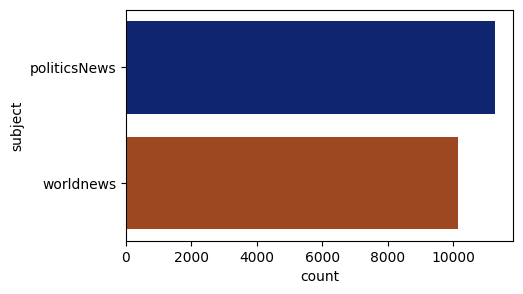

In [119]:
plt.figure(figsize=(5, 3))
sns.countplot(data = true_news_df, y = 'subject', palette= 'dark')
plt.show()

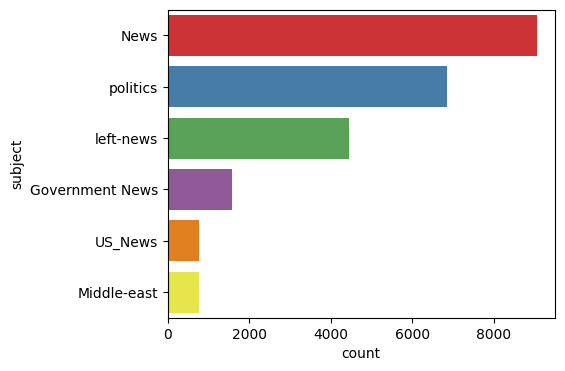

In [120]:
plt.figure(figsize= (5, 4) )
sns.countplot(data = fake_news_df, y = 'subject', 
              order = fake_news_df['subject'].value_counts().index,
              palette = "Set1")
plt.show()

In [121]:
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


#### Let's Add a New Column to true_news_df: , Add a New Column to fake_news_df: and Combine the Two DataFrames:
#### - Label the rows in true_news_df as 0 (indicating "true" news).
#### - Label the rows in fake_news_df as 1 (indicating "fake" news).
#### - Combine these two DataFrames into one final DataFrame (df_final), with a unified index and labels that distinguish between true and fake news.

In [122]:
true_news_df['is_fake'] = 0
fake_news_df['is_fake'] = 1
df_final = pd.concat([true_news_df, fake_news_df]).reset_index(drop = True)

In [123]:
df_final.head()

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


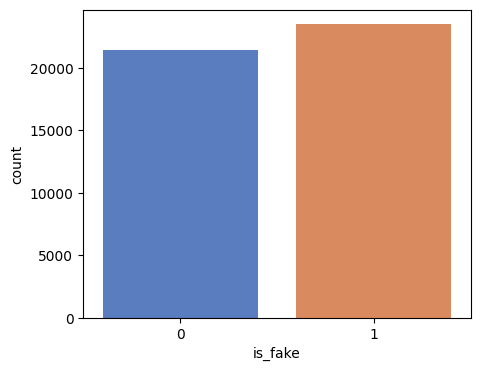

In [124]:
plt.figure(figsize= (5,4))
sns.countplot(data = df_final, x = 'is_fake', palette = 'muted')
plt.show()

In [125]:
df_final.drop(['date'], axis = 1, inplace = True)

In [126]:
df_final.head()

,title,text,subject,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0


#### We would be making the use of Missingno library from python. It is a very good graphical representation of missing values in our data. We see that there are many missing values in all data

In [127]:
import string
import wordcloud
import missingno as msno

<Figure size 300x300 with 0 Axes>

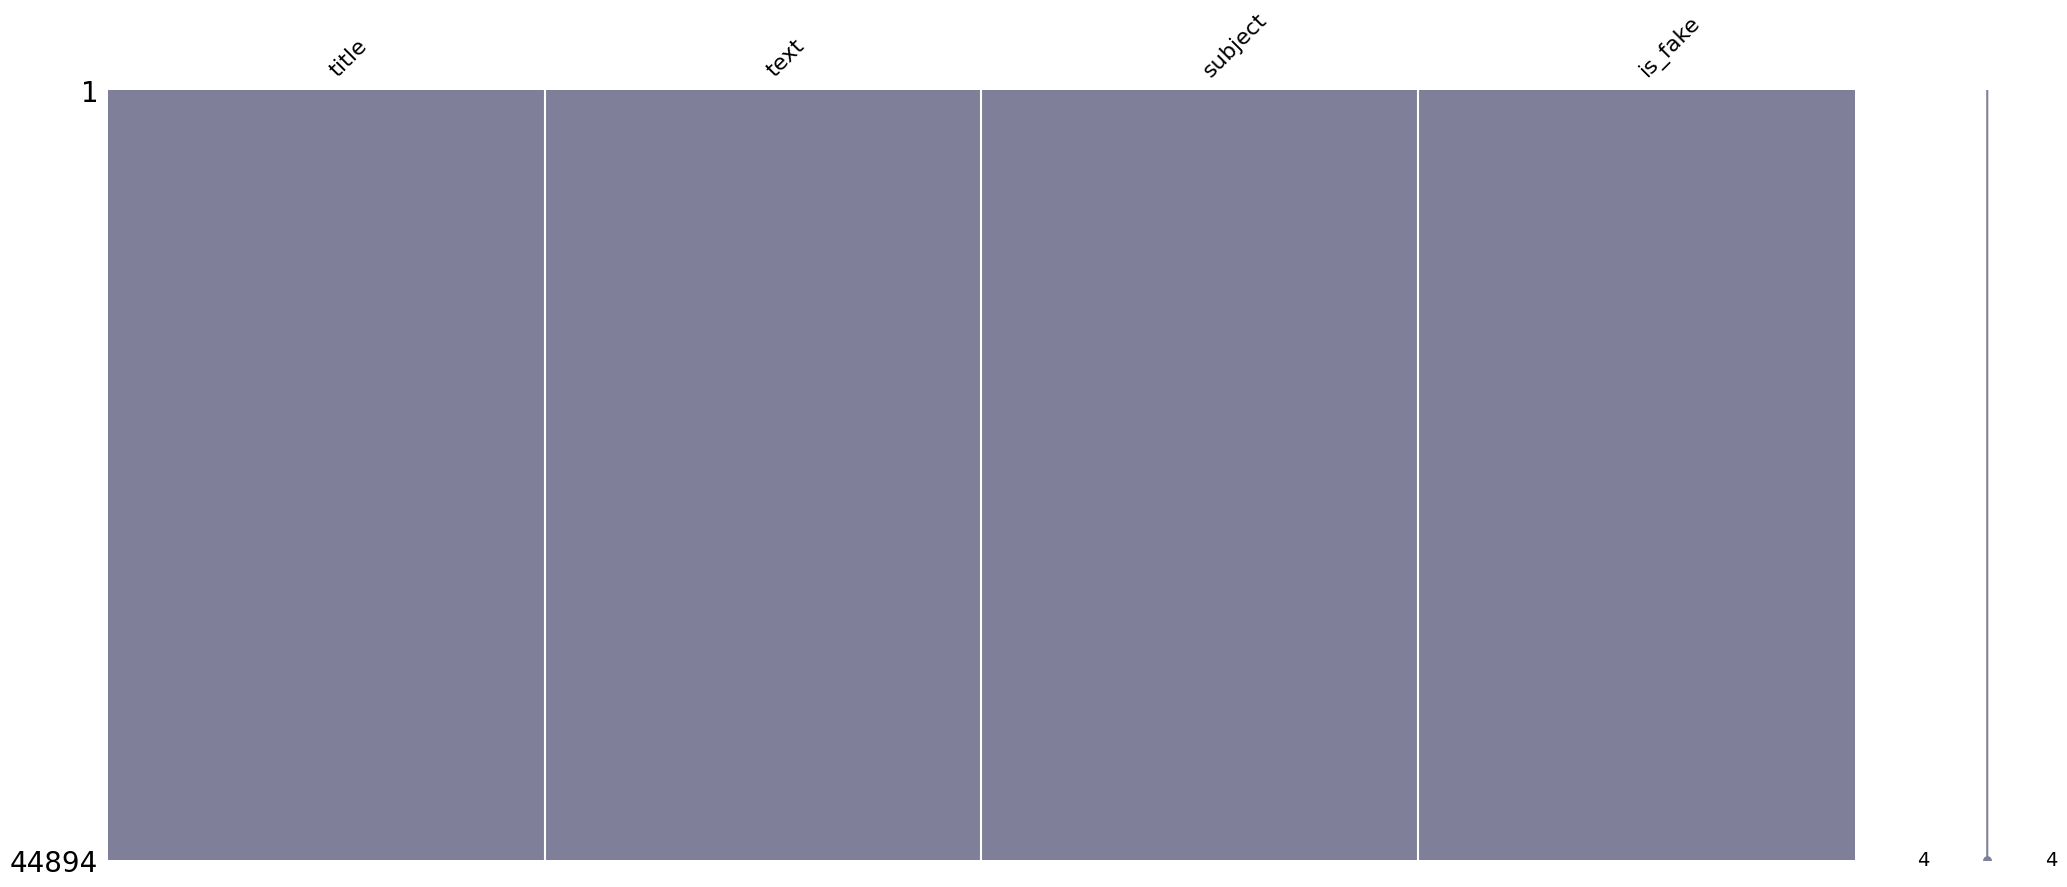

In [128]:
plt.figure(figsize=(3,3))
msno.matrix(df_final, color = (0.5, 0.5, 0.6))
plt.show()

In [130]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

# Load English stopwords
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dolla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dolla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [131]:
english_stopwords = stopwords.words('english')

In [132]:
# Printing the first 10 stopwords we are using in english
english_stopwords[0: 10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [133]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44894 entries, 0 to 44893
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44894 non-null  object
 1   text     44894 non-null  object
 2   subject  44894 non-null  object
 3   is_fake  44894 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [134]:
wordcloud.WordCloud()

The primary goal of the text_preprocessor function is to prepare raw text data by removing unnecessary elements and standardizing the text. This process makes the text data more suitable for further processing.

🌟 The `text_preprocessor` function cleans text data by:
- Removing punctuation,
- Converting words to lowercase,
- Lemmatizing words to their base form,
- Removing common stopwords,
- Reassembling the cleaned words into a single string.




In [135]:
def text_preprocessor(text):
    
    text_preprocessed = []
    text = text.translate(str.maketrans('', '', string.punctuation)) # Removes punctuations
    for word in text.split(' '): # Splits the text into words
        # print(word)
        word = word.lower()
        lemmatizer = WordNetLemmatizer()
        word = lemmatizer.lemmatize(word)
        if word not in english_stopwords:
            text_preprocessed.append(word)
    text_preprocessed = ' '.join(text_preprocessed)
    return text_preprocessed

In [136]:
df_final.head()

,title,text,subject,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0


#### Let's Apply the text processing to the `title` column

In [139]:
df_final['title preprocessed'] = df_final['title'].apply(text_preprocessor)

In [140]:
df_final.head()

,title,text,subject,is_fake,title preprocessed
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,u budget fight loom republican flip fiscal script
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,u military accept transgender recruit monday p...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,senior u republican senator let mr mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,trump want postal service charge much amazon s...


In [141]:
#### Let's Apply the text processing to the `text` column

In [142]:
# This cell can take a long time as we are preprocessing the entire text document
# It can execute in about 2-5 minutes
df_final['text preprocessed'] = df_final['text'].apply(text_preprocessor)

In [143]:
df_final.head()

,title,text,subject,is_fake,title preprocessed,text preprocessed
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,0,u budget fight loom republican flip fiscal script,washington reuters head conservative republic...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,0,u military accept transgender recruit monday p...,washington reuters transgender people allowed...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,0,senior u republican senator let mr mueller job,washington reuters special counsel investigat...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,0,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geo...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,0,trump want postal service charge much amazon s...,seattlewashington reuters president donald tr...


In [144]:
df_final.drop(['title', 'text'], axis = 1, inplace = True)

In [145]:
df_final.head()

,subject,is_fake,title preprocessed,text preprocessed
0,politicsNews,0,u budget fight loom republican flip fiscal script,washington reuters head conservative republic...
1,politicsNews,0,u military accept transgender recruit monday p...,washington reuters transgender people allowed...
2,politicsNews,0,senior u republican senator let mr mueller job,washington reuters special counsel investigat...
3,politicsNews,0,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geo...
4,politicsNews,0,trump want postal service charge much amazon s...,seattlewashington reuters president donald tr...


#### Now let's filter and separate the data from a DataFrame df_final based on a specific condition fake or true

In [146]:
fake_news = df_final[df_final.is_fake == 1]['title preprocessed']
true_news = df_final[df_final.is_fake == 0]['title preprocessed']

In [148]:
true_news.head()

0    u budget fight loom republican flip fiscal script
1    u military accept transgender recruit monday p...
2       senior u republican senator let mr mueller job
3    fbi russia probe helped australian diplomat ti...
4    trump want postal service charge much amazon s...
Name: title preprocessed, dtype: object

In [154]:
#Concatenating Fake News Titles
fake_news_title = ''.join(fake_news.to_list())
# Concatenating True News Titles
true_news_title = ''.join(true_news.to_list())

# this will help us for Word Cloud Generation: Generating word clouds from all titles combined.

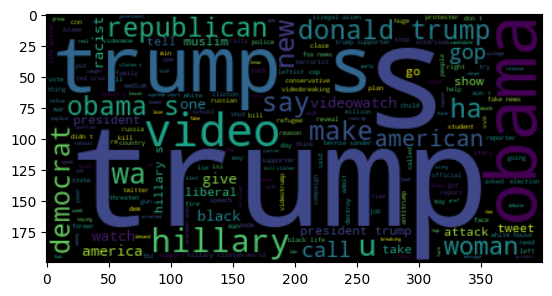

In [151]:
# Fake News Titles
word_cloud = wordcloud.WordCloud().generate(fake_news_title)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.show()

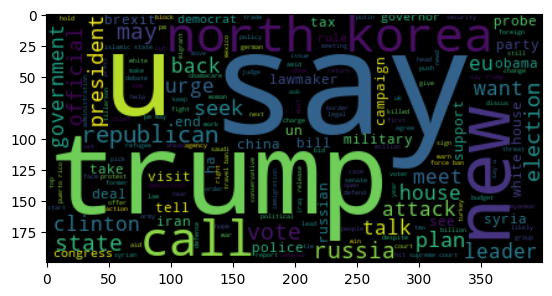

In [153]:
# True News Titles
word_cloud = wordcloud.WordCloud().generate(true_news_title)
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.show()

## Encoding Techniques

### Bag of Words (BOW)

In [160]:
X = df_final.drop(['is_fake'], axis = 1)
y = df_final['is_fake']

In [163]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: is_fake, dtype: int64

#### Let's split the data to Training and Testing

- train_test_split: Splits the dataset into training (70%) and testing (30%) subsets.
- random_state=101: This is a seed for the random number generator used to shuffle the data before splitting and Ensures reproducibility.


- Training Set: Used to train the model.
- Test Set: Used to evaluate model performance on unseen data.

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [165]:
print("The shape of training input data: {}".format(X_train.shape))
print("The shape of testing input data: {}".format(X_test.shape))
print("The shape of training output data: {}".format(y_train.shape))
print("The shape of testing output data: {}".format(y_test.shape))

The shape of training input data: (31425, 3)
The shape of testing input data: (13469, 3)
The shape of training output data: (31425,)
The shape of testing output data: (13469,)


In [167]:
X_train.head()

,subject,title preprocessed,text preprocessed
23367,News,rep ted lieu ha response sean spicer’s daily l...,rep ted lieu dca one loudest steadfast member ...
32550,politics,holy moly rebel medium uncovers illegal usacan...,never guess mainstream tv network right around...
11585,worldnews,u envoy say expects russia maintain big presen...,washington reuters russia likely maintain big...
38199,Government News,breaking obama’s “director diversity” donates ...,course anyone obama team fundamental transfor...
25739,News,florida governor us hurricane matthew excuse t...,florida republican governor rick scott allowin...


#### Bag of Words (BoW)
- The code snippet you provided is used for converting text data into a numerical format that can be fed into machine learning models. It uses a text vectorization technique called Bag of Words (BoW).

Purpose:
- Feature Extraction: Converts raw text data into a numerical format suitable for machine learning models.
- Training and Testing Consistency: Ensures that the test data is transformed using the same vocabulary and encoding scheme as the training data, which is crucial for model evaluation.
- `fit_transform`: Fits the vectorizer on the training data and transforms it.
- `Transforms`: Transforms the test data using the fitted vectorizer.

In [168]:
vectorizer = CountVectorizer()
title_train_bow = vectorizer.fit_transform(X_train['title preprocessed'])
title_test_bow = vectorizer.transform(X_test['title preprocessed'])

text_train_bow = vectorizer.fit_transform(X_train['text preprocessed'])
text_test_bow = vectorizer.transform(X_test['text preprocessed'])

- The hstack function combines these features into a single matrix for both the training and test sets. This allows the model to consider both the 'title' and 'text' features together.

In [170]:
X_train_transformed = hstack((title_train_bow, text_train_bow))
X_test_transformed = hstack((title_test_bow, text_test_bow))

### Logistic Regression

In [189]:
model = LogisticRegression()
model.fit(X_train_transformed, y_train)
y_predictions = model.predict(X_test_transformed)

In [195]:
error_mean_square = []
error_mean_absolute = []

In [196]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [172]:
y_predictions

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [173]:
accuracy_score(y_predictions, y_test)

0.9965847501670503

#### Now Let's use our Model to Predict new data

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression


In [185]:

# Sample new data
new_data = pd.DataFrame({
    'title preprocessed': [
        'trump threatens new sanctions',
        'new breakthrough in cancer research'
    ],
    'text preprocessed': [
        'trump announces possible new sanctions on iran amid rising tensions',
        'scientists discover new method to treat cancer using advanced technology'
    ]
})

# Initialize vectorizers
title_vectorizer = CountVectorizer()
text_vectorizer = CountVectorizer()

# Fit vectorizers on training data (use the same vectorizers fitted earlier)
title_vectorizer.fit(X_train['title preprocessed'])
text_vectorizer.fit(X_train['text preprocessed'])

# Transform new data
title_new_bow = title_vectorizer.transform(new_data['title preprocessed'])
text_new_bow = text_vectorizer.transform(new_data['text preprocessed'])
X_new_transformed = hstack((title_new_bow, text_new_bow))

# Initialize and train the model (using previously fitted model in practice)
model = LogisticRegression()
model.fit(X_train_transformed, y_train)

# Predict with the trained model
new_predictions = model.predict(X_new_transformed)

# Print predictions
print("Predictions for new data:")
for title, prediction in zip(new_data['title preprocessed'], new_predictions):
    print(f"Title: {title}\nPrediction: {'Fake' if prediction == 1 else 'True'}\n")


Predictions for new data:
Title: trump threatens new sanctions
Prediction: Fake

Title: new breakthrough in cancer research
Prediction: Fake



### K Neighbors Classifier

In [186]:
from sklearn.neighbors import KNeighborsClassifier

In [187]:
model = KNeighborsClassifier()
model.fit(X_train_transformed, y_train)
y_predictions = model.predict(X_test_transformed)

In [188]:
print(accuracy_score(y_predictions, y_test))
print(confusion_matrix(y_predictions, y_test))
print(classification_report(y_predictions, y_test))

0.7696933699606504
[[5089 1707]
 [1395 5278]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      6796
           1       0.76      0.79      0.77      6673

    accuracy                           0.77     13469
   macro avg       0.77      0.77      0.77     13469
weighted avg       0.77      0.77      0.77     13469



### Gradient Boosting Classifier

In [199]:
from sklearn.ensemble import GradientBoostingClassifier

In [200]:
model = GradientBoostingClassifier()
model.fit(X_train_transformed, y_train)
y_predictions = model.predict(X_test_transformed)

In [201]:
print(accuracy_score(y_predictions, y_test))
print(confusion_matrix(y_predictions, y_test))
print(classification_report(y_predictions, y_test))

0.9958423045511916
[[6474   46]
 [  10 6939]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6520
           1       0.99      1.00      1.00      6949

    accuracy                           1.00     13469
   macro avg       1.00      1.00      1.00     13469
weighted avg       1.00      1.00      1.00     13469



### Decision Tree Classifier

In [202]:
model = DecisionTreeClassifier()
model.fit(X_train_transformed, y_train)
y_predictions = model.predict(X_test_transformed)

In [203]:
print(accuracy_score(y_predictions, y_test))
print(confusion_matrix(y_predictions, y_test))
print(classification_report(y_predictions, y_test))

0.9974756849060806
[[6466   16]
 [  18 6969]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6482
           1       1.00      1.00      1.00      6987

    accuracy                           1.00     13469
   macro avg       1.00      1.00      1.00     13469
weighted avg       1.00      1.00      1.00     13469



### Random Forest Classifier

In [204]:
from sklearn.ensemble import RandomForestClassifier

In [205]:
model = RandomForestClassifier()
model.fit(X_train_transformed, y_train)
y_predictions = model.predict(X_test_transformed)

In [206]:
print(accuracy_score(y_predictions, y_test))
print(confusion_matrix(y_predictions, y_test))
print(classification_report(y_predictions, y_test))

0.9922785655950702
[[6455   75]
 [  29 6910]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      6530
           1       0.99      1.00      0.99      6939

    accuracy                           0.99     13469
   macro avg       0.99      0.99      0.99     13469
weighted avg       0.99      0.99      0.99     13469



## TFIDF Vectorizer

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [210]:
vectorizer = TfidfVectorizer()
title_train_tfidf = vectorizer.fit_transform(X_train['title preprocessed'])
title_test_tfidf = vectorizer.transform(X_test['title preprocessed'])

text_train_tfidf = vectorizer.fit_transform(X_train['text preprocessed'])
text_test_tfidf = vectorizer.transform(X_test['text preprocessed'])

In [60]:
X_train_transformed = hstack((title_train_tfidf, text_train_tfidf))
X_test_transformed = hstack((title_test_tfidf, text_test_tfidf))

## Word2Vec Vectorizer

In [61]:
import gensim

In [62]:
from gensim.models import Word2Vec

In [63]:
train_title = [text.split(' ') for text in X_train['title preprocessed']]
test_title = [text.split(' ') for text in X_test['title preprocessed']]

In [64]:
word2vec = Word2Vec(train_title, min_count = 2)

In [65]:
word2vec.wv.similarity('trump', 'hillary')

0.61654294

In [66]:
word2vec.wv.similarity('apple', 'email')

0.80205226

In [67]:
word2vec.wv.most_similar('trump')

[('trump’s', 0.861196756362915),
 ('oliver', 0.8531867861747742),
 ('obama', 0.8469250798225403),
 ('psychiatrist', 0.8407729864120483),
 ('aug', 0.8398065567016602),
 ('anonymous', 0.8300782442092896),
 ('noam', 0.8270716071128845),
 ('trump…blames', 0.8264898657798767),
 ('cream', 0.8224700689315796),
 ('bette', 0.8176900744438171)]

In [68]:
word2vec.wv.most_similar('laptop')

[('funeral', 0.9973785281181335),
 ('flood', 0.9973040223121643),
 ('illegals', 0.9972101449966431),
 ('truck', 0.9970853924751282),
 ('ring', 0.9970752596855164),
 ('museum', 0.9970503449440002),
 ('“refugees”', 0.9966311454772949),
 ('since', 0.9966306090354919),
 ('mass', 0.9966155290603638),
 ('several', 0.996551513671875)]

In [69]:
train_title[0]

['lois',
 'lerner',
 'email',
 'snippet',
 'reveal',
 'bitter',
 'btch',
 '“lincoln',
 'let',
 'south',
 'go…”']

In [70]:
test_title[0]

['factbox',
 'humanitarian',
 'crisis',
 'worsens',
 'bangladesh',
 'many',
 'rohingya',
 'flee',
 'myanmar']

 - This technique is based on the idea that each word in a document is represented as a vector in a continuous vector space (such as Word2Vec), and the document can be represented as the average of these word vectors.

In [ ]:
df_final['title preprocessed'] = df_final['title'].apply(text_preprocessor)

In [71]:
avgword2vec_train = []
for i in range(len(train_title)):
    word2vec_sum = 0
    for j in range(len(train_title[i])):
        try: 
            word2vec_sum = word2vec_sum + word2vec.wv.word_vec(train_title[i][j])           
        except KeyError:
            continue
    avg_word2vec = word2vec_sum / (j + 1)
    avgword2vec_train.append(avg_word2vec)

In [72]:
avgword2vec_df_train = pd.DataFrame()
avgword2vec_df_test = pd.DataFrame()

In [73]:
from tqdm import tqdm 

In [74]:
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [75]:
# This file can take about 5 minutes to run the code cell 

y_train_transformed = []
for i in tqdm(range(len(avgword2vec_train))):
    try:
        avgword2vec_df_train = avgword2vec_df_train.append(pd.DataFrame(avgword2vec_train[i]).T)
        y_train_transformed.append(y_train[i])
    except ValueError:
        continue

100%|████████████████████████████████████████████████████████████████████████████| 31428/31428 [06:35<00:00, 79.38it/s]


In [76]:
avgword2vec_test = []
for i in range(len(test_title)):
    word2vec_sum = 0
    for j in range(len(test_title[i])):
        try: 
            word2vec_sum = word2vec_sum + word2vec.wv.word_vec(test_title[i][j])
        except KeyError: 
            continue
    avg_word2vec = word2vec_sum / (j + 1)
    avgword2vec_test.append(avg_word2vec)

In [77]:
# This file can take about 5 minutes to run the code cell 

y_test_transformed = []
for i in tqdm(range(len(avgword2vec_test))):
    try:
        avgword2vec_df_test = avgword2vec_df_test.append(pd.DataFrame(avgword2vec_test[i]).T)
        y_test_transformed.append(y_test[i])
    except ValueError:
        continue

100%|████████████████████████████████████████████████████████████████████████████| 13470/13470 [02:34<00:00, 87.21it/s]


In [78]:
model = LogisticRegression()
model.fit(avgword2vec_df_train, y_train_transformed)
y_predictions = model.predict(avgword2vec_df_test)

In [79]:
y_predictions

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [80]:
accuracy_score(y_predictions, y_test_transformed)

0.9117974608359938

In [81]:
print(classification_report(y_predictions, y_test_transformed))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6402
           1       0.92      0.91      0.92      7067

    accuracy                           0.91     13469
   macro avg       0.91      0.91      0.91     13469
weighted avg       0.91      0.91      0.91     13469

